<font color="#CC3D3D"><p>
# Build models

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, KFold

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,...,4.280446,7,0.056338,2,0.0,디자이너,0.797297,26836200.0,0.0,5.0
1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,...,6.144365,67,0.500000,1,0.0,스포츠,0.333333,0.0,0.0,NaN
2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,...,6.144365,355,0.000000,1,0.0,NaN,0.000000,0.0,0.0,NaN
3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,...,3.657564,17,0.000000,1,2.0,NaN,0.750000,1609600.0,131560.0,NaN
4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,...,0.707107,47,0.000000,1,0.0,NaN,0.333333,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,7,7,8,40,0.642857,...,1.154701,30,0.428571,2,1.0,NaN,0.571429,24950000.0,0.0,NaN
5978,480000,1,480000,480000,1,1,1,1,0,0.000000,...,6.144365,343,0.000000,1,0.0,NaN,1.000000,480000.0,0.0,NaN
5979,260003790,71,3662025,25750000,38,28,19,19,18,0.915493,...,5.183891,1,0.028169,1,6.0,NaN,0.211268,33210000.0,1057500.0,NaN
5980,88991520,18,4943973,18120000,9,7,5,5,60,0.444444,...,1.341641,23,0.000000,1,5.0,NaN,0.777778,0.0,0.0,NaN


### 2. EDA

In [3]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

GridSpec(6, 6)

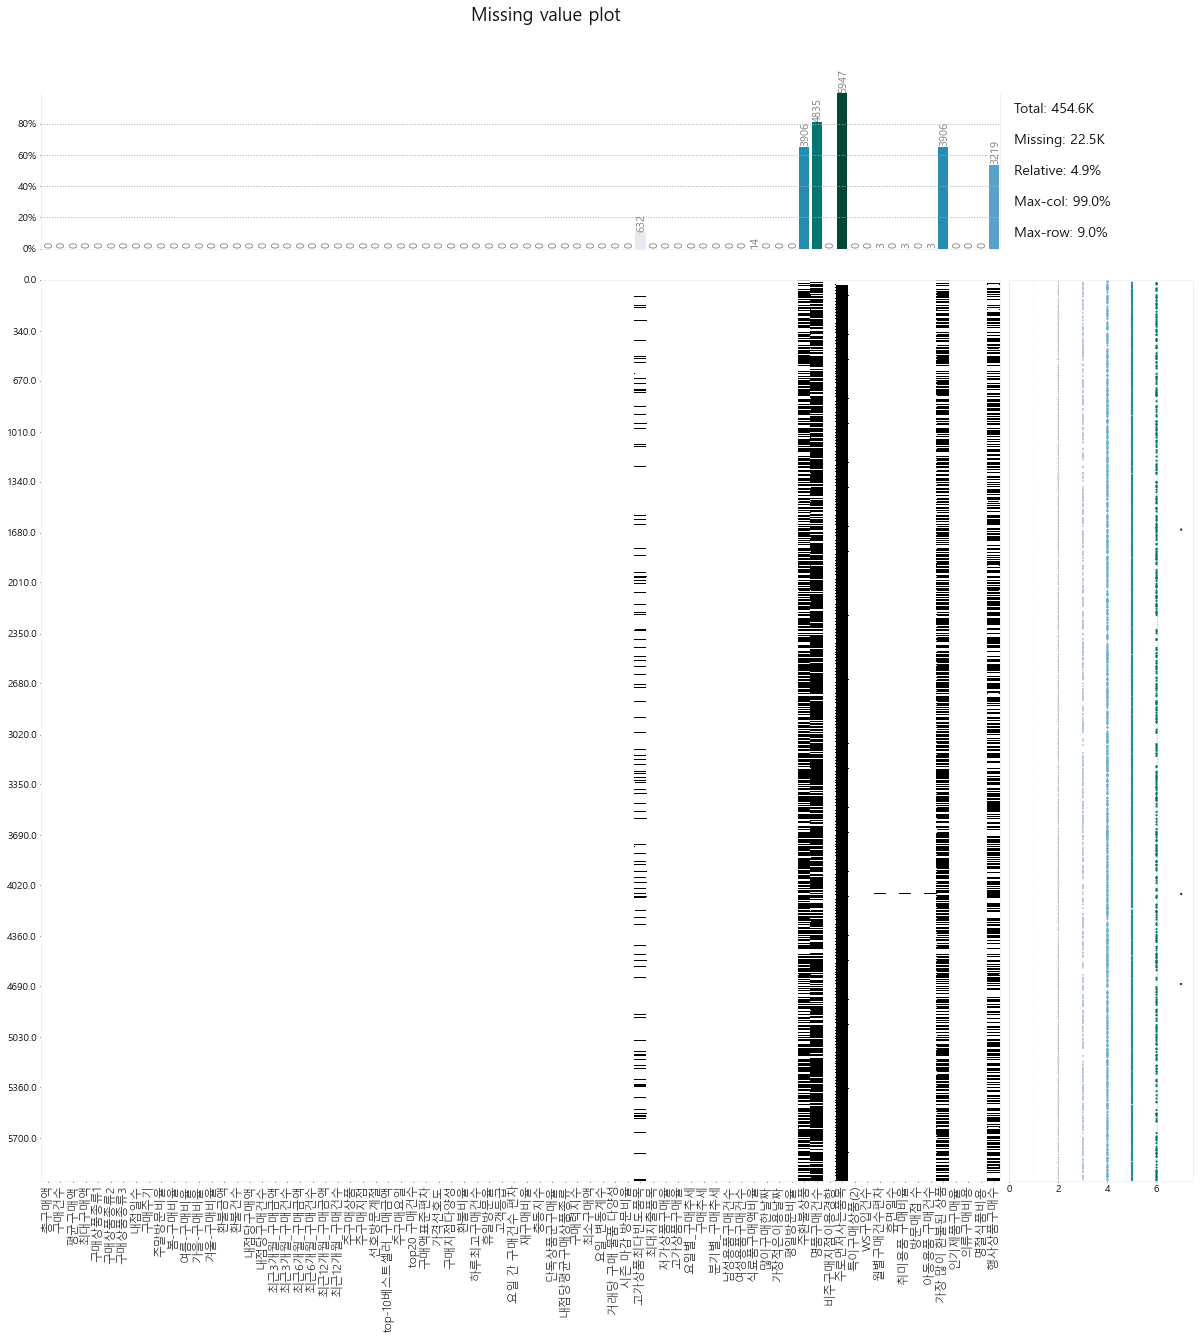

In [4]:
# 결측값 파악

klib.missingval_plot(features)

Note: The number of non binary numerical features is very large (62), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


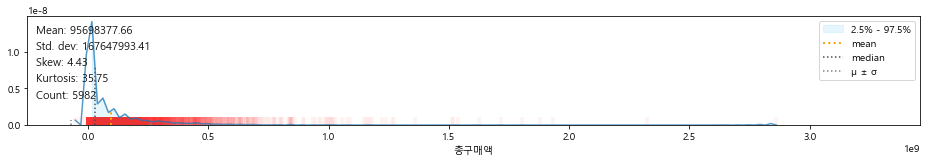

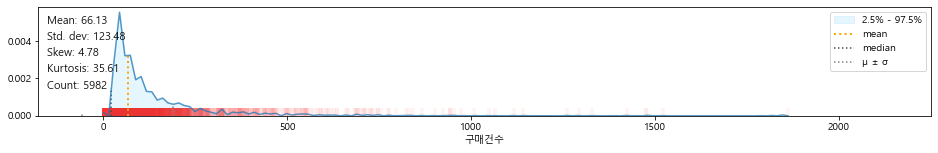

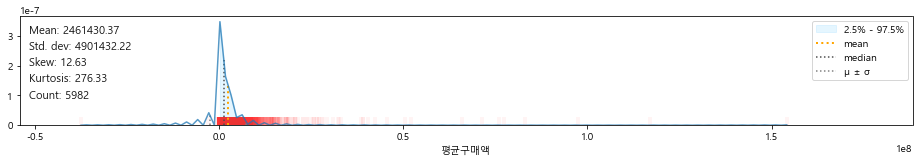

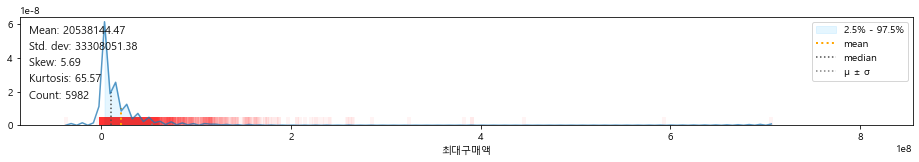

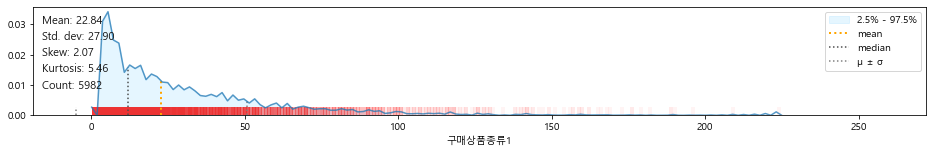

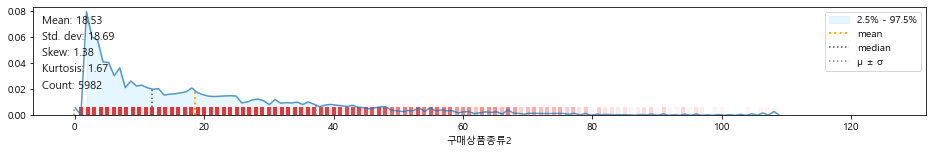

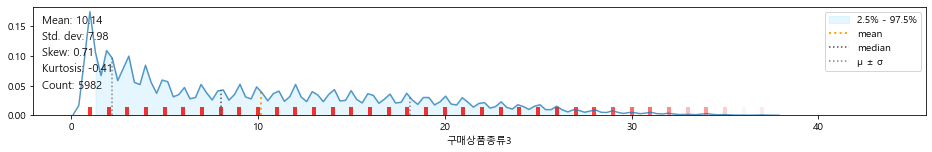

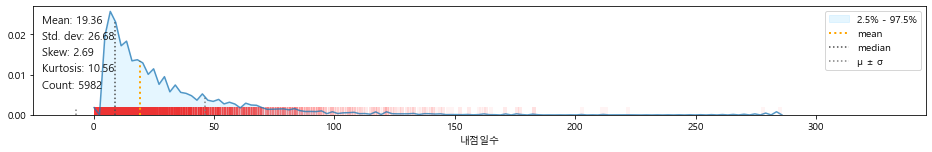

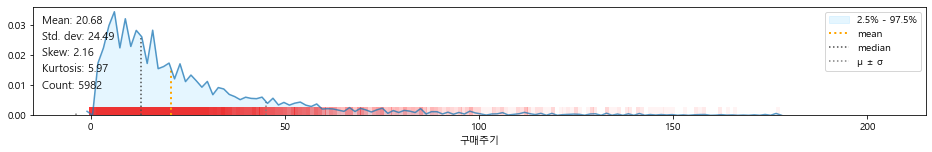

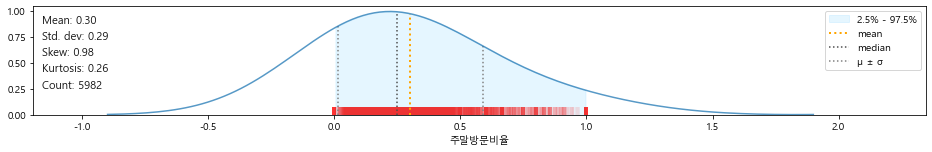

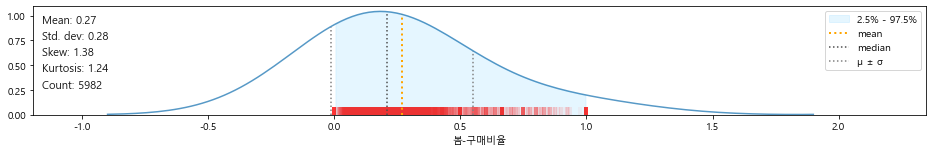

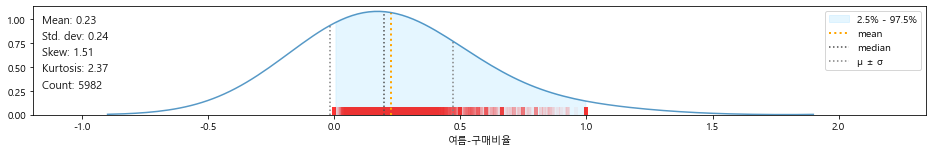

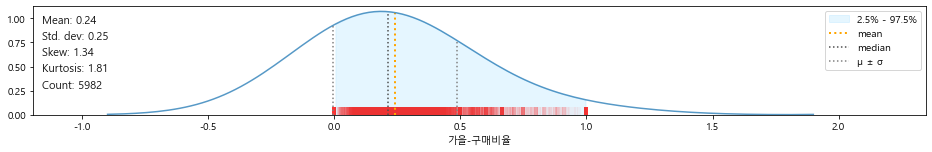

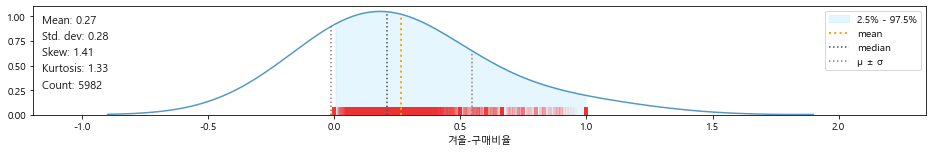

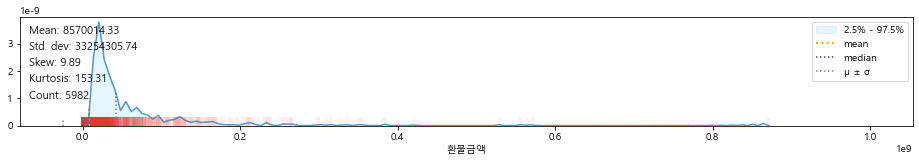

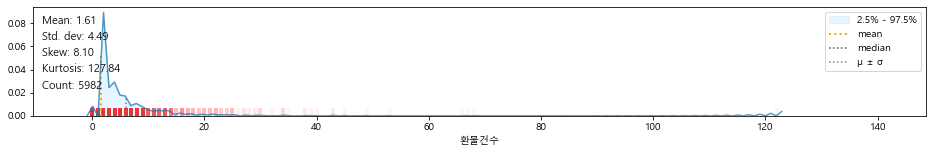

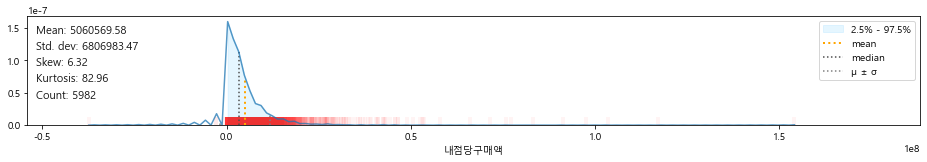

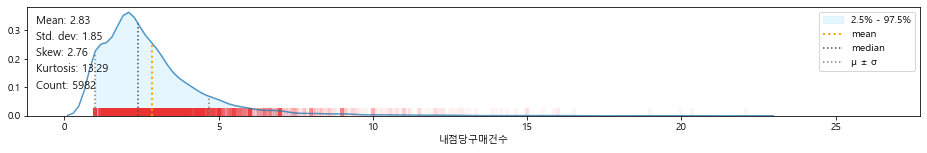

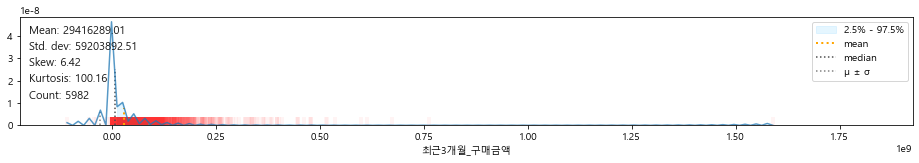

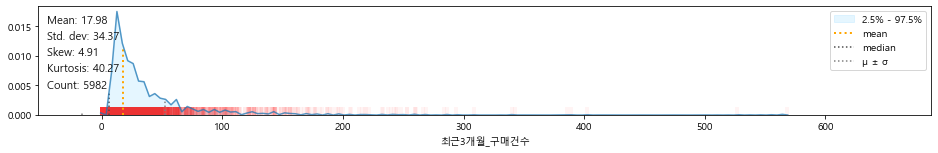

In [5]:
# 수치형 속성 파악

klib.dist_plot(features)

GridSpec(6, 14)

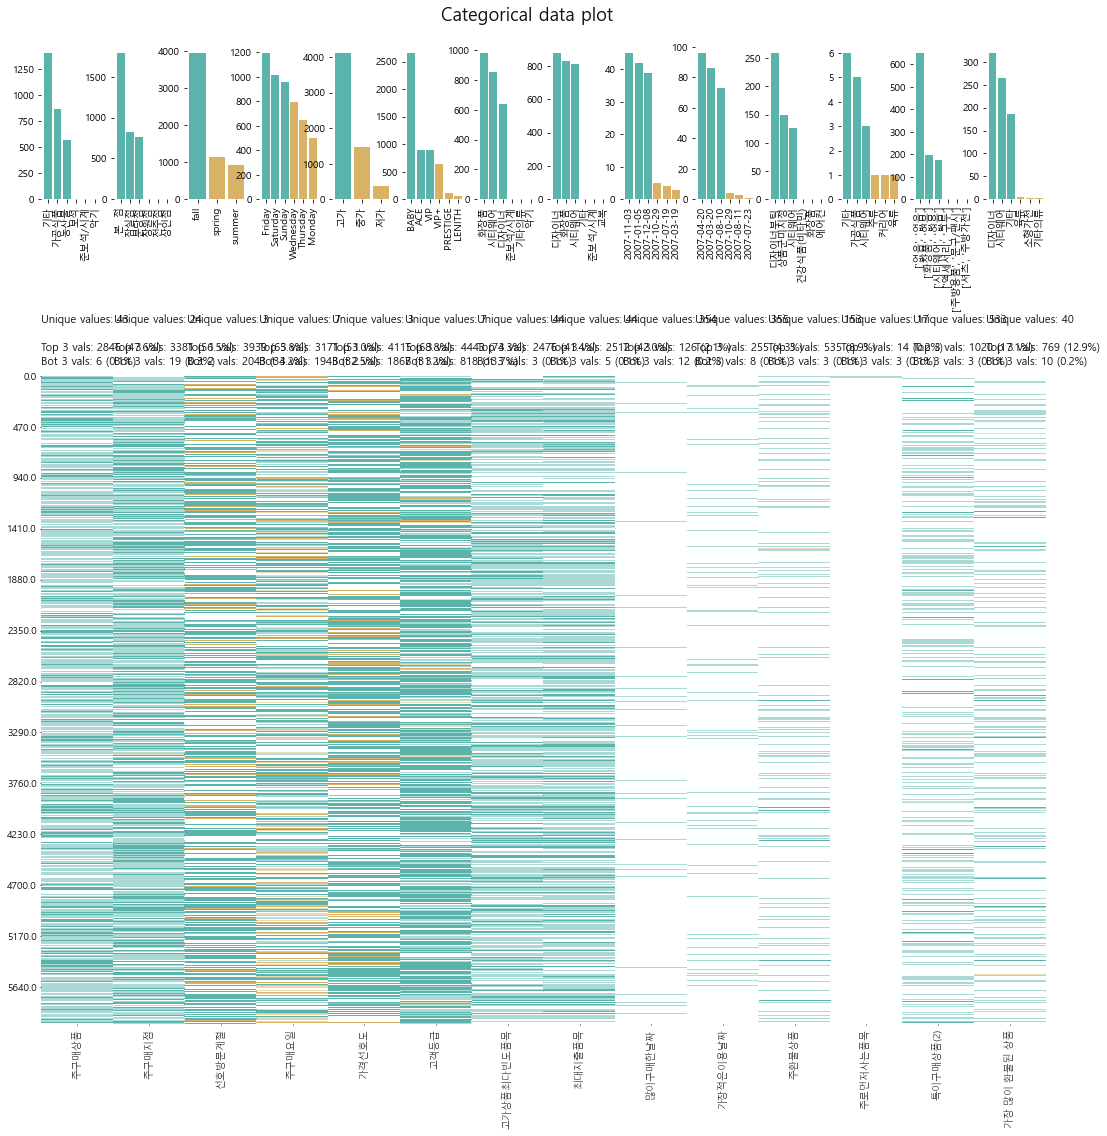

In [6]:
# 범주형 속성 파악

klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to further limit the results.


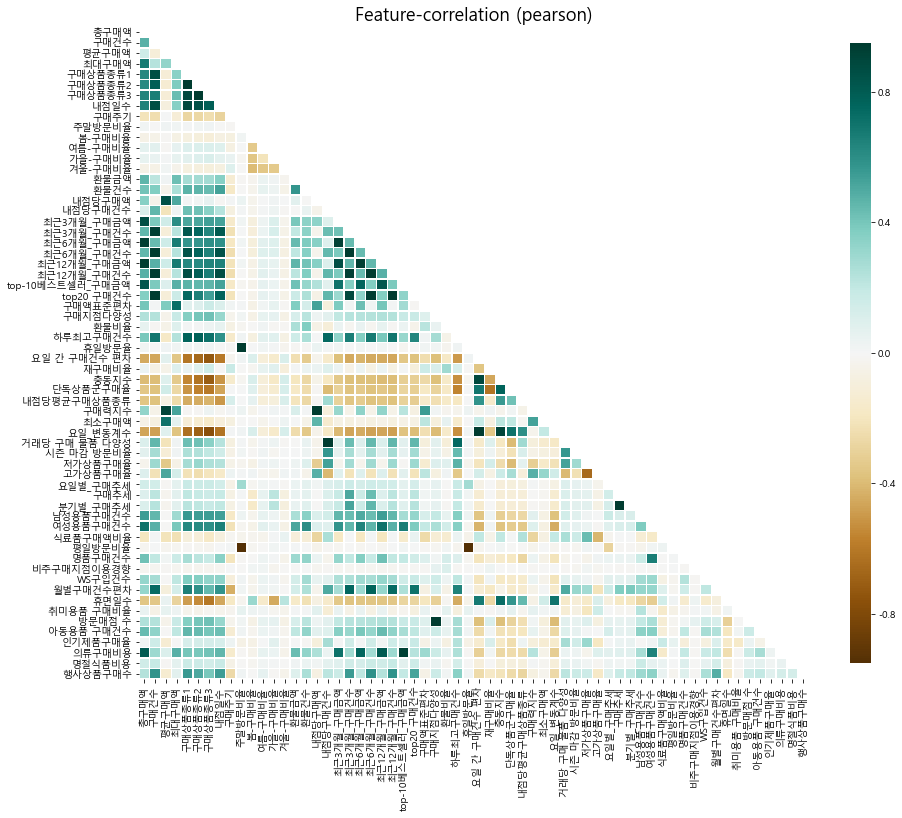

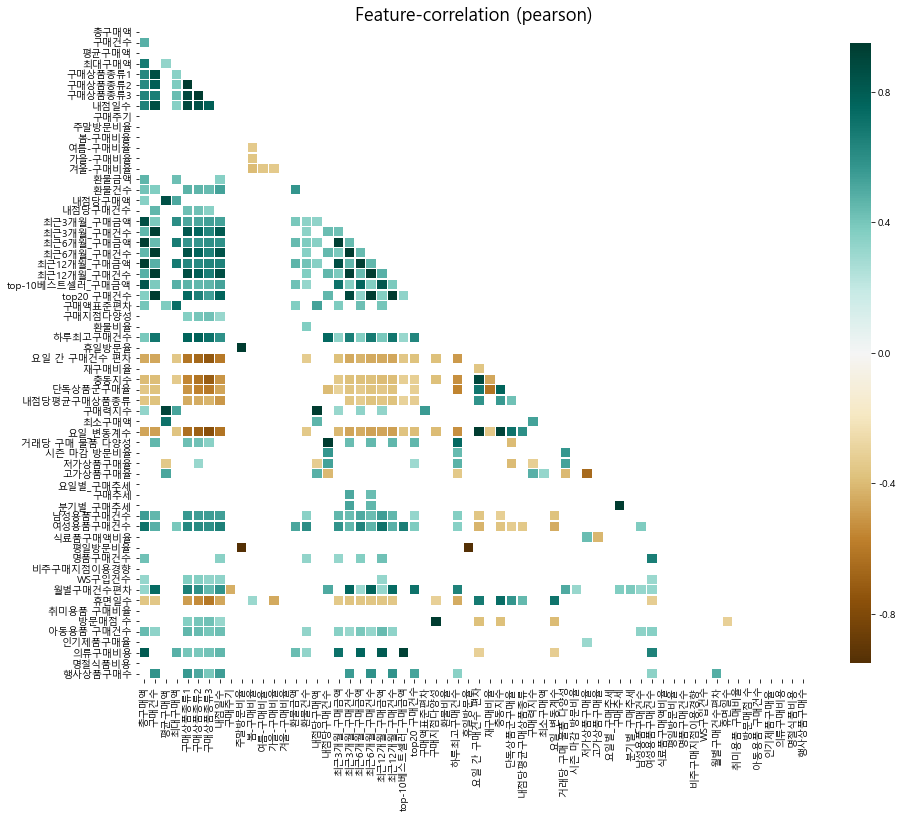

In [7]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,12))

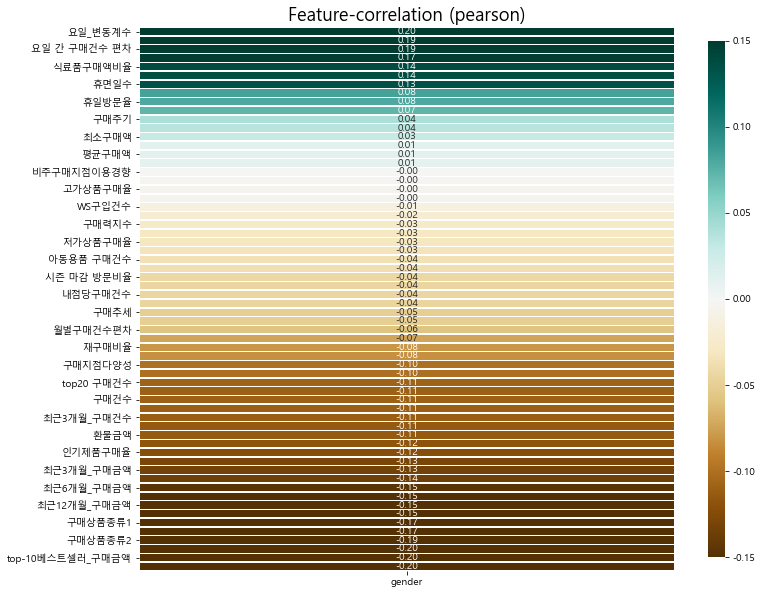

In [8]:
# 속성별 예측 능력 파악 

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

### 3. Data Cleansing & Feature Engineering

In [9]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [10]:
# 결측값 처리
features[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(features[num_features])
features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,68282840.0,74.0,922741.0,11264000.0,35.0,28.0,17.0,19.0,17.0,0.527027,...,4.280446,7.0,0.056338,2.0,0.0,디자이너,0.797297,26836200.0,0.0,5.0
1,2136000.0,3.0,712000.0,2136000.0,2.0,2.0,2.0,2.0,1.0,0.000000,...,6.144365,67.0,0.500000,1.0,0.0,스포츠,0.333333,0.0,0.0,0.0
2,3197000.0,4.0,799250.0,1639000.0,1.0,2.0,2.0,2.0,1.0,0.000000,...,6.144365,355.0,0.000000,1.0,0.0,디자이너,0.000000,0.0,0.0,0.0
3,16077620.0,44.0,365400.0,4935000.0,24.0,20.0,13.0,18.0,16.0,0.318182,...,3.657564,17.0,0.000000,1.0,2.0,디자이너,0.750000,1609600.0,131560.0,0.0
4,29050000.0,3.0,9683333.0,24000000.0,2.0,3.0,3.0,2.0,85.0,0.000000,...,0.707107,47.0,0.000000,1.0,0.0,디자이너,0.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500.0,14.0,5898679.0,23976000.0,8.0,7.0,7.0,8.0,40.0,0.642857,...,1.154701,30.0,0.428571,2.0,1.0,디자이너,0.571429,24950000.0,0.0,0.0
5978,480000.0,1.0,480000.0,480000.0,1.0,1.0,1.0,1.0,0.0,0.000000,...,6.144365,343.0,0.000000,1.0,0.0,디자이너,1.000000,480000.0,0.0,0.0
5979,260003790.0,71.0,3662025.0,25750000.0,38.0,28.0,19.0,19.0,18.0,0.915493,...,5.183891,1.0,0.028169,1.0,6.0,디자이너,0.211268,33210000.0,1057500.0,0.0
5980,88991520.0,18.0,4943973.0,18120000.0,9.0,7.0,5.0,5.0,60.0,0.444444,...,1.341641,23.0,0.000000,1.0,5.0,디자이너,0.777778,0.0,0.0,0.0


*Deal with Outliers*

In [11]:
# 수치형 변수에 대해 이상치(outlier)를 처리
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [12]:
# 수치형 변수를 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,월별구매건수편차,휴면일수,취미용품 구매비율,방문매점 수,아동용품 구매건수,가장 많이 환불된 상품,인기제품구매율,의류구매비용,명절식품비용,행사상품구매수
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.850730,0.971813,0.634090,0.287488,0.961537,...,0.039431,-0.822503,1.290370,1.240190,-0.718630,디자이너,0.359725,0.743415,-0.452314,1.406253
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0.591289,0.469238,1.927647,-0.738074,-0.718630,스포츠,-1.264955,-1.431893,-0.452314,-0.881935
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0.591289,1.527697,-0.714587,-0.738074,-0.718630,디자이너,-1.852923,-1.431893,-0.452314,-0.881935
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.519375,0.608433,0.593285,0.237687,0.328410,...,-0.174737,-0.356755,-0.714587,-0.738074,1.379647,디자이너,0.140590,0.069733,2.207418,-0.881935
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-1.010055,-0.902317,-0.993810,1.730289,-1.318162,...,-1.614815,0.244927,-0.714587,-0.738074,-0.718630,디자이너,-1.264955,-1.431893,-0.452314,-0.881935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.404322,-0.124258,-0.020766,1.085903,1.227595,...,-1.319980,-0.028639,1.927647,1.240190,0.987909,디자이너,-0.570157,0.723285,-0.452314,-0.881935
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.571532,-1.558223,-1.375368,-1.541375,-1.318162,...,0.591289,1.527697,-0.714587,-0.738074,-0.718630,디자이너,1.461909,-0.163114,-0.452314,-0.881935
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.850730,1.130977,0.634090,0.335229,1.699113,...,0.321196,-1.557191,0.638579,-0.738074,1.691185,디자이너,-1.526019,0.803183,2.215797,-0.881935
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.404322,-0.463380,-0.369851,1.531439,0.738583,...,-1.209292,-0.184749,-0.714587,-0.738074,1.661438,디자이너,0.267636,-1.431893,-0.452314,-0.881935


*Encode Categorical Variables*

In [13]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,가장 많이 환불된 상품_주방가전,가장 많이 환불된 상품_주방용품,가장 많이 환불된 상품_차/커피,가장 많이 환불된 상품_침구/수예,가장 많이 환불된 상품_캐주얼,가장 많이 환불된 상품_커리어,가장 많이 환불된 상품_통신/컴퓨터,가장 많이 환불된 상품_트래디셔널,가장 많이 환불된 상품_피혁잡화,가장 많이 환불된 상품_화장품
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.850730,0.971813,0.634090,0.287488,0.961537,...,0,0,0,0,0,0,0,0,0,0
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0,0,0,0,0,0,0,0,0,0
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-1.248270,-1.188198,-0.993810,-1.210683,-1.318162,...,0,0,0,0,0,0,0,0,0,0
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.519375,0.608433,0.593285,0.237687,0.328410,...,0,0,0,0,0,0,0,0,0,0
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-1.010055,-0.902317,-0.993810,1.730289,-1.318162,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.404322,-0.124258,-0.020766,1.085903,1.227595,...,0,0,0,0,0,0,0,0,0,0
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.571532,-1.558223,-1.375368,-1.541375,-1.318162,...,0,0,0,0,0,0,0,0,0,0
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.850730,1.130977,0.634090,0.335229,1.699113,...,0,0,0,0,0,0,0,0,0,0
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.404322,-0.463380,-0.369851,1.531439,0.738583,...,0,0,0,0,0,0,0,0,0,0


*Feature Correlation*

https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

In [14]:
corr = features.corr().apply(lambda x: x.abs())
columns = np.full((corr.shape[0],), True, dtype=bool) #컬럼개수만큼 True 생성
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8: 
            if columns[j]:
                columns[j] = False #i컬럼과 상관관계가 높은 j컬럼을 False
selected_columns = corr.columns[columns]
features = features[selected_columns]

*Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [02:03<00:00,  1.30s/it]

(17, 0.7709596360583147)


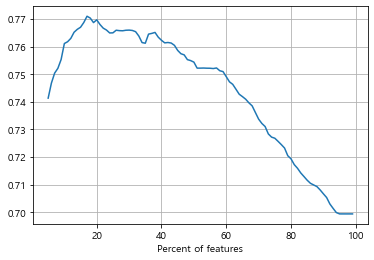

In [15]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [16]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 280)
['총구매액', '구매건수', '평균구매액', '여름-구매비율', '가을-구매비율', '겨울-구매비율', '환불금액', '내점당구매건수', '최근3개월_구매금액', '구매지점다양성', '재구매비율', '단독상품군구매율', '내점당평균구매상품종류', '시즌 마감 방문비율', '저가상품구매율', '요일별_구매추세', '구매추세', '남성용품구매건수', '여성용품구매건수', '식료품구매액비율', '명품구매건수', '월별구매건수편차', '아동용품 구매건수', '인기제품구매율', '의류구매비용', '명절식품비용', '행사상품구매수', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_일용잡화', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_전주점', '선호방문계절_fall', '선호방문계절_spring', '선호방문계절_summer', '주구매요일_Friday', '주구매요일_Saturday', '가격선호도_고가', '가격선호도_저가', '고객등급_ACE', '고객등급_CROWN', '고객등급_LENITH', '고객등급_PRESTIGE', '고객등급_VIP+', '고가상품최다빈도품목_가공식품', '고가상품최다빈도품목_골프', '고가상품최다빈도품목_구두', '고가상품최다빈도품목_남성 캐주얼', '고가상품최다빈도품목_남성정장', '고가상품최다빈도품목_농산물', '고가상품최다빈도품목_디자이너', '고가상품최다빈도품목_명품', '고가상품최다빈도품목_모피/피혁', '고가상품최다빈도품목_섬유잡화', '고가상품최다빈도품목_셔츠', '고가상품최다빈도품목_스포츠', '고가상품최다빈도

### 4. Model Tuning (Hyperparameter Optimization)
-Bayesian Optimization

### 1) XGB

In [17]:
#하이퍼파라미터를 각 함수의 인자로 넣는다.
def xgb_evaluate(n_estimators, learning_rate ,numLeaves,maxDepth,gamma,colsample,min_child_weight):
    params = {
        'n_estimators' : int(n_estimators),
        'learning_rate' : learning_rate,
        'num_leaves' : int(numLeaves),
        'max_depth' : int(maxDepth),
        'gamma' : gamma,
        'colsample' : colsample,
        'min_child_weight' : int(min_child_weight)
        
    }
    xgb = XGBClassifier(**params,random_state=0)
    skf = StratifiedKFold(n_splits=5 , random_state=0)
    scores = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)

#함수에 들어갈 인자를 각각 넣는다.
xgbBO = BayesianOptimization(xgb_evaluate, 
                             {'n_estimators':(100, 500),
                              'learning_rate': (0.005, 0.1) ,
                              'numLeaves':  (30, 70),
                              'maxDepth': (3, 8),
                              'gamma' : (0,5),
                              'colsample': (0.5, 1),
                              'min_child_weight':(0,20)},
                            random_state=0)
xgbBO.maximize(init_points=5, n_iter=30) #init_points는 초기랜덤포인트 개수, n_iter: 반복횟수

|   iter    |  target   | colsample |   gamma   | learni... | maxDepth  | min_ch... | n_esti... | numLeaves |
-------------------------------------------------------------------------------------------------------------
[22:55:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:55:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

[22:56:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  4        |  0.7434   |  0.8996   |  2.307    |  0.07915  |  3.591    |  12.8     |  157.3    |  67.79    |
[22:56:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:56:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner

[22:56:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:56:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  8        |  0.7445   |  0.6182   |  2.987    |  0.04698  |  3.012    |  13.97    |  180.9    |  49.05    |
[22:56:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner

[22:56:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:56:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:56:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

[22:57:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

[22:57:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

[22:57:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:57:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

[22:58:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:58:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:58:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

[22:58:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:58:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:58:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, num_leaves } might not be used.

  This may not be accurate due to some par

In [18]:
xgbBO.max

{'target': 0.7446564244042551,
 'params': {'colsample': 0.7777856608238427,
  'gamma': 3.0317053220486354,
  'learning_rate': 0.04007634319865448,
  'maxDepth': 3.1634759490929936,
  'min_child_weight': 13.842623834323982,
  'n_estimators': 357.41563228507295,
  'numLeaves': 56.40910159958677}}

In [19]:
max_xgbBO_params = xgbBO.max['params']

max_xgbBO_params['n_estimators'] = int(round(max_xgbBO_params['n_estimators']))
max_xgbBO_params['maxDepth'] = int(round(max_xgbBO_params['maxDepth']))
max_xgbBO_params['numLeaves'] = int(round(max_xgbBO_params['numLeaves']))
max_xgbBO_params['min_child_weight'] = int(round(max_xgbBO_params['min_child_weight']))


max_xgbBO_params

{'colsample': 0.7777856608238427,
 'gamma': 3.0317053220486354,
 'learning_rate': 0.04007634319865448,
 'maxDepth': 3,
 'min_child_weight': 14,
 'n_estimators': 357,
 'numLeaves': 56}

In [20]:
skf = StratifiedKFold(n_splits=5 , random_state=0)

In [21]:
xgbBO_clf = XGBClassifier(**max_xgbBO_params, random_state = 0)

scores = cross_val_score(xgbBO_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print('최대성능: ',max(scores),'\n평균성능: ',np.mean(scores))

최대성능:  0.7671385439959628 
평균성능:  0.7388175285294709


In [22]:
#Bayesian Optimization 최적 결과 저장
BOclfs_tuned = []
BOclfs_tuned.append((type(xgbBO_clf).__name__,xgbBO_clf))

### 2) LGBM

In [23]:
def lgb_evaluate(learning_rate,n_estimators ,numLeaves, maxDepth):
    params = {
        'learning_rate' : learning_rate,
        'n_estimators': int(round(n_estimators)),
        'num_leaves': int(numLeaves),
        'max_depth': int(maxDepth),
    }
    lgb = LGBMClassifier(**params,random_state=0)
    skf = StratifiedKFold(n_splits=5 , random_state=0)
    scores = cross_val_score(lgb, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)

lgbBO = BayesianOptimization(lgb_evaluate, 
                             {'learning_rate':(0.005, 1),
                              'n_estimators' : (100, 500),
                              'numLeaves':  (50, 100),
                              'maxDepth': (4, 8) },
                             random_state=0)
lgbBO.maximize(init_points=5, n_iter=30)


|   iter    |  target   | learni... | maxDepth  | n_esti... | numLeaves |
-------------------------------------------------------------------------
|  1        |  0.696    |  0.5511   |  6.861    |  341.1    |  77.24    |
|  2        |  0.7012   |  0.4265   |  6.584    |  275.0    |  94.59    |
|  3        |  0.6962   |  0.9638   |  5.534    |  416.7    |  76.44    |
|  4        |  0.6987   |  0.5702   |  7.702    |  128.4    |  54.36    |
|  5        |  0.7301   |  0.02512  |  7.33     |  411.3    |  93.5     |
|  6        |  0.6924   |  0.5983   |  7.214    |  367.0    |  75.62    |
|  7        |  0.6992   |  0.4496   |  4.523    |  355.7    |  58.81    |
|  8        |  0.7      |  0.6168   |  7.426    |  434.3    |  81.02    |
|  9        |  0.692    |  0.9128   |  5.134    |  366.7    |  54.28    |
|  10       |  0.7323   |  0.005    |  7.585    |  410.6    |  93.41    |
|  11       |  0.7281   |  0.005    |  8.0      |  407.1    |  96.77    |
|  12       |  0.7279   |  0.005    | 

In [24]:
lgbBO.max

{'target': 0.7322912358032363,
 'params': {'learning_rate': 0.005,
  'maxDepth': 7.585329161142952,
  'n_estimators': 410.6491130619048,
  'numLeaves': 93.41471403498322}}

In [25]:
max_lgbBO_params = lgbBO.max['params']

max_lgbBO_params['n_estimators'] = int(round(max_lgbBO_params['n_estimators']))
max_lgbBO_params['maxDepth'] = int(round(max_lgbBO_params['maxDepth']))
max_lgbBO_params['numLeaves'] = int(round(max_lgbBO_params['numLeaves']))

max_lgbBO_params

{'learning_rate': 0.005, 'maxDepth': 8, 'n_estimators': 411, 'numLeaves': 93}

In [26]:
lgbBO_clf = LGBMClassifier(**max_lgbBO_params, random_state=0)

scores = cross_val_score(lgbBO_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print('최대성능: ',max(scores),'\n평균성능: ',np.mean(scores))

최대성능:  0.7798461685707077 
평균성능:  0.7375845599435183


In [27]:
BOclfs_tuned.append((type(lgbBO_clf).__name__,lgbBO_clf))

### 3) GB

In [28]:
def GB_evaluate(learning_rate, max_depth, subsample, n_estimators, min_samples_split, min_samples_leaf):
    params = {
        'learning_rate' : learning_rate,
        'subsample' : subsample,
        'max_depth': int(max_depth),
        'n_estimators': int(round(n_estimators)),
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf': int(round(min_samples_leaf))
    }
    GB = GradientBoostingClassifier(**params,random_state=0)
    skf = StratifiedKFold(n_splits=5 , random_state=0)
    scores = cross_val_score(GB, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)

GBBO = BayesianOptimization(GB_evaluate,
                            {'learning_rate' : (0.05, 2),
                             'subsample' : (0.5,1),
                             'max_depth': (3,8),
                             'n_estimators': (100,500),
                             'min_samples_split' :(30,100),
                             'min_samples_leaf': (3,10)},
                           random_state=0)
GBBO.maximize(init_points=5, n_iter=25)


|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.6887   |  1.12     |  6.576    |  7.219    |  68.14    |  269.5    |  0.8229   |
|  2        |  0.6899   |  0.9033   |  7.459    |  9.746    |  56.84    |  416.7    |  0.7644   |
|  3        |  0.6609   |  1.158    |  7.628    |  3.497    |  36.1     |  108.1    |  0.9163   |
|  4        |  0.5552   |  1.567    |  7.35     |  9.85     |  85.94    |  284.6    |  0.8903   |
|  5        |  0.7046   |  0.2806   |  6.2      |  4.003    |  96.13    |  308.7    |  0.7073   |
|  6        |  0.6973   |  0.8189   |  5.827    |  5.552    |  68.49    |  268.7    |  0.9096   |
|  7        |  0.7472   |  0.05     |  3.0      |  3.0      |  64.4     |  255.4    |  1.0      |
|  8        |  0.5134   |  1.913    |  4.852    |  3.015    |  47.23    |  254.7    |  0.6      |
|  9        |  0.719

In [29]:
GBBO.max

{'target': 0.7472256151523649,
 'params': {'learning_rate': 0.05,
  'max_depth': 3.0,
  'min_samples_leaf': 3.0,
  'min_samples_split': 64.39824898797343,
  'n_estimators': 255.4174599716862,
  'subsample': 1.0}}

In [30]:
max_GBBO_params = GBBO.max['params']

max_GBBO_params['n_estimators'] = int(round(max_GBBO_params['n_estimators']))
max_GBBO_params['max_depth'] = int(round(max_GBBO_params['max_depth']))
max_GBBO_params['min_samples_split'] = int(round(max_GBBO_params['min_samples_split']))
max_GBBO_params['min_samples_leaf'] = int(round(max_GBBO_params['min_samples_leaf']))


max_GBBO_params

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 64,
 'n_estimators': 255,
 'subsample': 1.0}

In [31]:
skf = StratifiedKFold(n_splits=5 , random_state=0)

In [32]:
GBBO_clf = GradientBoostingClassifier(**max_GBBO_params, random_state=0)

scores = cross_val_score(GBBO_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print('최대성능: ',max(scores),'\n평균성능: ',np.mean(scores))

최대성능:  0.7906439515883443 
평균성능:  0.7472256151523649


In [33]:
BOclfs_tuned.append((type(GBBO_clf).__name__,GBBO_clf))

### 4) RF

In [34]:
def RF_evaluate(max_depth,n_estimators, min_samples_split, max_features):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(round(n_estimators)),
        'min_samples_split' : int(round(min_samples_split)),
        'max_features' : max_features
    }
    RF = RandomForestClassifier(**params,random_state=0)
    skf = StratifiedKFold(n_splits=5 , random_state=0)
    scores = cross_val_score(RF, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)

RFBO = BayesianOptimization(RF_evaluate, 
                            {'max_depth': (3,8),
                             'n_estimators': (100,500),
                             'min_samples_split' :(30,100),
                             'max_features' : (0.8,1)},
                           random_state=0)
RFBO.maximize(init_points=5, n_iter=25)


|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7346   |  5.744    |  0.943    |  72.19    |  318.0    |
|  2        |  0.7348   |  5.118    |  0.9292   |  60.63    |  456.7    |
|  3        |  0.7395   |  7.818    |  0.8767   |  85.42    |  311.6    |
|  4        |  0.7342   |  5.84     |  0.9851   |  34.97    |  134.9    |
|  5        |  0.7223   |  3.101    |  0.9665   |  84.47    |  448.0    |
|  6        |  0.7393   |  7.539    |  0.8      |  93.07    |  320.3    |
|  7        |  0.7357   |  5.668    |  0.994    |  99.68    |  299.6    |
|  8        |  0.7397   |  7.412    |  0.8277   |  85.23    |  310.0    |
|  9        |  0.7351   |  5.11     |  0.8678   |  30.02    |  469.7    |
|  10       |  0.7397   |  7.327    |  0.8      |  100.0    |  350.8    |
|  11       |  0.7299   |  4.321    |  0.8425   |  97.75    |  376.7    |
|  12       |  0.7397   |  7.755    | 

In [35]:
RFBO.max

{'target': 0.741301931940008,
 'params': {'max_depth': 8.0,
  'max_features': 1.0,
  'min_samples_split': 100.0,
  'n_estimators': 359.4942237492301}}

In [36]:
max_RFBO_params = RFBO.max['params']

max_RFBO_params['n_estimators'] = int(round(max_RFBO_params['n_estimators']))
max_RFBO_params['max_depth'] = int(round(max_RFBO_params['max_depth']))
max_RFBO_params['min_samples_split'] = int(round(max_RFBO_params['min_samples_split']))

max_RFBO_params

{'max_depth': 8,
 'max_features': 1.0,
 'min_samples_split': 100,
 'n_estimators': 359}

In [37]:
skf = StratifiedKFold(n_splits=5 , random_state=0)

In [38]:
RFBO_clf = RandomForestClassifier(**max_RFBO_params,random_state=0)

scores = cross_val_score(RFBO_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print('최대성능: ',max(scores),'\n평균성능: ',np.mean(scores))

최대성능:  0.7847665120811618 
평균성능:  0.741301931940008


In [39]:
BOclfs_tuned.append((type(RFBO_clf).__name__,RFBO_clf))

### 5) ET

In [40]:
def ET_evaluate(max_depth, n_estimators, min_samples_split, min_samples_leaf):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(round(n_estimators)),
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf': int(round(min_samples_leaf))
    }
    ET = ExtraTreesClassifier(**params, random_state=0)
    skf = StratifiedKFold(n_splits=5 , random_state=0)
    scores = cross_val_score(ET, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)

ETBO = BayesianOptimization(ET_evaluate, 
                            {'max_depth': (3,8),
                             'n_estimators': (100,500),
                             'min_samples_split' :(30,100),
                             'min_samples_leaf': (3,10)},
                           random_state=0)
ETBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7216   |  5.744    |  8.006    |  72.19    |  318.0    |
|  2        |  0.721    |  5.118    |  7.521    |  60.63    |  456.7    |
|  3        |  0.7309   |  7.818    |  5.684    |  85.42    |  311.6    |
|  4        |  0.7208   |  5.84     |  9.479    |  34.97    |  134.9    |
|  5        |  0.7085   |  3.101    |  8.828    |  84.47    |  448.0    |
|  6        |  0.7309   |  7.722    |  3.201    |  91.46    |  317.1    |
|  7        |  0.7214   |  5.668    |  9.79     |  99.68    |  299.6    |
|  8        |  0.7312   |  7.946    |  4.18     |  89.83    |  317.7    |
|  9        |  0.7266   |  6.423    |  3.338    |  99.81    |  342.6    |
|  10       |  0.7088   |  3.594    |  8.927    |  97.69    |  375.1    |
|  11       |  0.7306   |  7.999    |  4.424    |  30.11    |  483.1    |
|  12       |  0.7081   |  3.629    | 

In [41]:
ETBO.max

{'target': 0.7332451504451158,
 'params': {'max_depth': 8.0,
  'min_samples_leaf': 5.24277786733705,
  'min_samples_split': 100.0,
  'n_estimators': 215.56796224055654}}

In [42]:
max_ETBO_params = ETBO.max['params']

max_ETBO_params['n_estimators'] = int(round(max_ETBO_params['n_estimators']))
max_ETBO_params['max_depth'] = int(round(max_ETBO_params['max_depth']))
max_ETBO_params['min_samples_split'] = int(round(max_ETBO_params['min_samples_split']))
max_ETBO_params['min_samples_leaf'] = int(round(max_ETBO_params['min_samples_leaf']))


max_ETBO_params

{'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 100,
 'n_estimators': 216}

In [43]:
skf = StratifiedKFold(n_splits=5 , random_state=0)

In [44]:
ETBO_clf = ExtraTreesClassifier(**max_ETBO_params,random_state=0)

scores = cross_val_score(ETBO_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print('최대성능: ',max(scores),'\n평균성능: ',np.mean(scores))

최대성능:  0.7750824407688092 
평균성능:  0.7332451504451158


In [45]:
BOclfs_tuned.append((type(ETBO_clf).__name__,ETBO_clf))

### 5. Model Ensemble

In [46]:
BOclfs_tuned

[('XGBClassifier',
  XGBClassifier(base_score=None, booster=None, colsample=0.7777856608238427,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, gamma=3.0317053220486354, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                learning_rate=0.04007634319865448, maxDepth=3,
                max_delta_step=None, max_depth=None, min_child_weight=14,
                missing=nan, monotone_constraints=None, n_estimators=357,
                n_jobs=None, numLeaves=56, num_parallel_tree=None, random_state=0,
                reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
                subsample=None, tree_method=None, validate_parameters=None,
                verbosity=None)),
 ('LGBMClassifier',
  LGBMClassifier(learning_rate=0.005, maxDepth=8, n_estimators=411, numLeaves=93,
                 random_state=0)),
 ('GradientBoostingClassifier',
  GradientBoostingClassifier(learning_rate=0.05,

In [95]:
estimators = [#(BOclfs_tuned[0][0],BOclfs_tuned[0][1]), #(모델, 최적파라미터) XGB
              #(BOclfs_tuned[1][0],BOclfs_tuned[1][1]), #LGBM
              (BOclfs_tuned[2][0],BOclfs_tuned[2][1]), #GB
              (BOclfs_tuned[3][0],BOclfs_tuned[3][1]), #RF
              #(BOclfs_tuned[4][0],BOclfs_tuned[4][1]), #ET
              ]
ensemble_softVoting = VotingClassifier(estimators = estimators, voting='soft')

In [96]:
skf = StratifiedKFold(n_splits=5 , shuffle=False, random_state=77)
ensemble_score = np.mean(cross_val_score(ensemble_softVoting, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1))
print('ensemble_softvoting 성능:', ensemble_score)

ensemble_softvoting 성능: 0.748485510227097


In [98]:
ensemble_softVoting.fit(X_train,y_train)

ensemble = ensemble_softVoting.predict_proba(X_test)[:,1]

### 6. Deployment

In [99]:
pd.DataFrame({'cust_id':test_id, 'gender':ensemble}).set_index('cust_id').to_csv('박준영-submit-2.csv', index=False, encoding='cp949')

<font color="#CC3D3D"><p>
# End